# Softmax

## 这里会有两个版本，一个是手写版，另一个是Pytorch简单版本

In [1]:
%matplotlib inline
import numpy as np
import seaborn as sns
import torch
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt

import torchvision
from torch.utils import data
from torchvision import transforms

函数清单：
  - 图像数据iterator
  - 定义模型
  - 定义参数
  - 定义loss
  - 定义optimizer
  - 定义metric
  - 训练过程

In [52]:
transformers = transforms.Compose([transforms.ToTensor()])

mnist_train = torchvision.datasets.FashionMNIST(root="../data", train=True, download=True, transform=transformers)
mnist_test = torchvision.datasets.FashionMNIST(root="../data", train=False, download=True, transform=transformers)

train_data_loader = torch.utils.data.DataLoader(mnist_train, batch_size=32, shuffle=True, num_workers=0)
test_data_loader = torch.utils.data.DataLoader(mnist_test, batch_size=32, shuffle=False, num_workers=0)

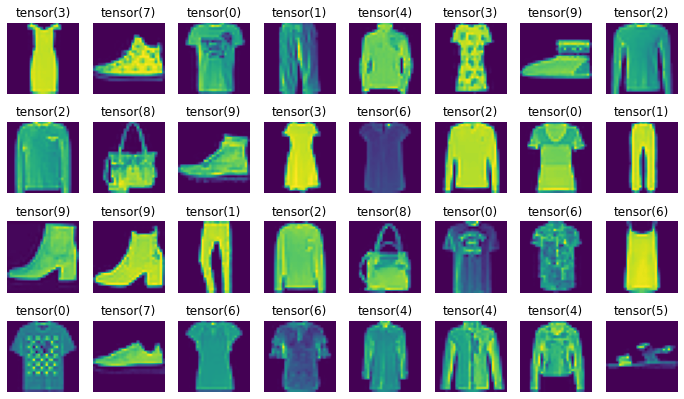

In [117]:
def plot_batch(batch):
    """Plot batch in fashion_mnist

    Parameters
    ----------
    batch : one batch in iterator, (X, y): X is the image, y is the label
    """
    num, _,  rx, ry = batch[0].shape
    batch_img = batch[0].reshape(num, rx, ry)
    batch_label = batch[1]

    fig, axes = plt.subplots(4, num//4, figsize=(12, 7))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        ax.set_axis_off()
        ax.set_title(batch_label[i])
        ax.imshow(batch_img[i])
    plt.show()
    
batch = next(iter(train_data_loader))
plot_batch(batch)

In [363]:
## 定义参数
output_num = 10
W = torch.normal(0., 0.01, size=(784, output_num), requires_grad=True)
b = torch.normal(0., 0.01, size=(1, output_num), requires_grad=True)

## 定义模型
def model(W, b, X):
    y = torch.matmul(X.reshape(X.shape[0], -1), W) + b
    y_softmax = torch.exp(y) / torch.exp(y).sum()
    return y_softmax

## 定义loss
def entropy(y, y_hat):
    return -torch.log10(y_hat[range(y_hat.shape[0]), y])

## 定义optimizer
def sgd(params, lr=0.01, batch_size=32):
    
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()
            
## 定义metrics
class Accumulator():
    """A simple Accumulator which help accumulate a list while evaluation
    """
    def __init__(self, n):
        self.data = [0.] * n
    
    def add(self, *args):
        for arg in args:
            self.data = [a + float(b) for a,b in zip(self.data, arg)]
    
    def reset(self):
        self.data = [0.] * len(self.data)
    
    def __get_item__(self, idx):
        return self.data[idx]


def accuracy_iter(model, data_iter):
    """AI is creating summary for accuracy_iter

    Parameters
    ----------
    model : Function of Tensor
        Return a single Tensor
    data_iter : Iterator
        Usually an iterator yields batch data

    Returns
    -------
    List of floats
        return [loss_of_average, accuracy_of_average, false_rate_of_average]
    """
    
    accu = Accumulator(4)
    with torch.no_grad():
        
        for X, y in data_iter:
            y_hat = model(W, b, X)
            cnt = len(y)
            loss = entropy(y, y_hat).sum()
            acc_t = (y_hat.argmax(axis=1) == y).sum()
            acc_f = (y_hat.argmax(axis=1) != y).sum()
            accu.add([cnt, loss, acc_t, acc_f])
            
    return [x/accu.data[0] for x in accu.data][1:]


## Animation Class
from IPython import display

class Animation():
    
    def __init__(self, epoch_show_num, xlim=None, ylim=[0, 10], secondary=True, xlabel="Epoch"):
        
        import matplotlib.pyplot as plt
        self.epoch_show_num = epoch_show_num
        self.fig, self.ax = plt.subplots(1, 1, figsize=(8,4))
        self.ax.set_xticks(range(epoch_show_num))
        self.ax.set_xlabel(xlabel)
        # self.ax.set_ylim(*ylim)
        self.data = {"l": []}
        
        if secondary == True:
            self.ax2 = self.ax.twinx()
            self.data["r"] = []
            
        self.secondary = secondary

    def add_data(self, data, side='l'):
                
        if self.data[side]:
            self.data[side] = [a + [x] for a, x in zip(self.data[side], data)]
        else:
            self.data[side] = [[x] for x in data]
            
        
    def add(self, data_l, data_r=None, legends_l=None, legends_r=None):
                
        if legends_l is None:
            legends_l = list(range(len(data_l)))
        if legends_r is None:
            legends_r = list(range(len(data_r)))
            
        if data_l:
            self.add_data(data_l, "l")
        if data_r:
            self.add_data(data_r, "r")
        
        self.ax.cla()
        self.ax2.cla()
        
        alpha_l = 1
        alpha_r = 1
                
        for data_l_list, label in zip(self.data['l'], legends_l):
            self.ax.plot(range(len(data_l_list)), data_l_list, label=label, alpha=alpha_l, color='b')
            alpha_l /= 2
        
        if self.secondary:
            for data_r_list, label in zip(self.data['r'], legends_r):
                self.ax2.plot(range(len(data_r_list)), data_r_list, label=label, color='r', alpha=alpha_r, linestyle="--")
                self.ax2.set_xticks(range(self.epoch_show_num))
                self.ax2.set_ylim(0.5, 1)
                alpha_r /= 2


        plt.legend()
        
        if self.secondary:
            plt.grid("minor", axis='both')
        else:
            plt.grid("major", axis='both')

        
        display.display(self.fig)
        
        display.clear_output(wait=True)


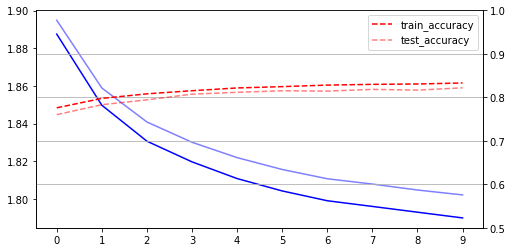

In [364]:
## 训练模型
epoch_num = 10
lr=0.01
batch_size=32

animation = Animation(epoch_show_num=epoch_num, secondary=True)

for epoch in range(epoch_num):
    
    for batch_X, batch_y in iter(train_data_loader):
    
        batch_y_hat = model(W, b, batch_X)
        batch_loss = entropy(batch_y, batch_y_hat)
        batch_loss.sum().backward()
        sgd([W, b], lr, batch_size)
    
    rst_1 = accuracy_iter(model, iter(train_data_loader))
    rst_2 = accuracy_iter(model, iter(test_data_loader))
    
    
    animation.add(
        data_l=[rst_1[0], rst_2[0]], data_r=[rst_1[1], rst_2[1]],   
        legends_l=["train_loss", "test_loss"], legends_r=["train_accuracy", "test_accuracy"])
    





简洁版本

函数清单：
  - 获取数据
  - 定义模型
  - 定义参数
  - 定义loss
  - 定义optimize
  - 定义metrics
  

In [354]:
batch = next(iter(train_data_loader))


def metrics_iter(model, data_iter, funcs):
    
    accu = Accumulator(4)
    with torch.no_grad():
        
        for X, y in data_iter:
            y_hat = model(X.reshape(X.shape[0], -1))
            rst = [len(y)]
            for func in funcs:
                rst.append(func(y_hat, y))
            # acc_t = (y_hat.argmax(axis=1) == y).sum()
            # acc_f = (y_hat.argmax(axis=1) != y).sum()
            accu.add(rst)
            
    return [x/accu.data[0] for x in accu.data][1:]



# X, y = next(iter(train_data_loader))
# y_hat = model(X.reshape(X.shape[0], -1))
# y_hat.shape, y.shape
# loss(y_hat, y)

# lambda y, y_hat: (y_hat.argmax(axis=1) == y).sum()

tensor(2.2479, grad_fn=<NllLossBackward>)

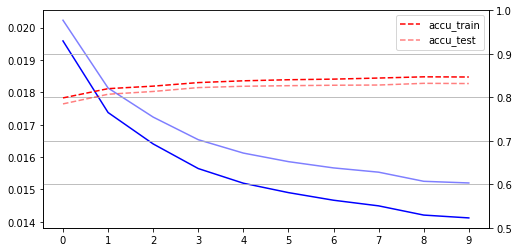

In [362]:
epoch_num = 10

##定义模型
def softmax(input_num, output_num):
    
    layer = torch.nn.Sequential(
        torch.nn.Linear(input_num, output_num),
    )
    
    return layer
#定义参数
model = softmax(28*28, 10)
model[0].weight.data.normal_(0, 0.01)
model[0].bias.data.normal_(0, 0.01)
##定义loss
loss = torch.nn.CrossEntropyLoss()
##定义optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
##定义metrics
funcs = [loss, lambda y_hat, y: (y_hat.argmax(axis=1) == y).sum()]
##定义animator
animation = Animation(epoch_show_num=epoch_num, secondary=True)


for epoch in range(epoch_num):
    for batch_X, batch_y in iter(train_data_loader):
        
        batch_y_hat = model(batch_X.reshape(batch_X.shape[0], -1))
        batch_loss = loss(batch_y_hat, batch_y)
        
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        [loss_train, accu_train] = metrics_iter(model, train_data_loader, funcs)
        [loss_test, accu_test] = metrics_iter(model, test_data_loader, funcs)
        animation.add(data_l=[loss_train, loss_test], legends_l=["loss_train", "loss_test"], 
                      data_r=[accu_train, accu_test], legends_r=["accu_train", "accu_test"])

